In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
# Define some constants

FIG_SIZE = (7.3,4.5)
LINESTYLE = (0,(4,4))
FONT_SIZE = 16
STEP = 10 # Percentile steps to report slow down on
SAVE_FIG = False

LINES = ["-","--",":","-."]

BOLT_HDR_SIZE = 21. # Bytes
IP_HDR_SIZE = 20.   # Bytes
MTU = 5000.         # Bytes
ACK_SIZE = IP_HDR_SIZE + BOLT_HDR_SIZE
PKT_PAYLOAD_SIZE = MTU - ACK_SIZE

BWs = [100e9, 200e9, 400e9]  # bps
LINK_DELAY = 1048e-9 #  seconds
RTTs = [] 
for bw in BWs:
  RTTs.append( (MTU + ACK_SIZE) * 8. / bw * 2. + 4 * LINK_DELAY)
BDP_100G = BWs[0] * RTTs[0] / 8.0
BDP_400G = BWs[2] * RTTs[2] / 8.0

PORT_START_NO = 1000

START_TIME = 1.0 # seconds
STOP_TIME = START_TIME + 1.0 # only consider flows that finish before this

In [3]:
#@title
workload = 'Google_RPC_read'
note = '_incLineRates' # Should start with a _
load = 0.8
simIdx = 0
nHost = 64
hpcc_utgt = 95
hpcc_ai = 50

trace_path = 'outputs/bolt-star-topo/'
trace_path += workload + '_load-' + str(int(load*100)) + 'p'
trace_path += '_nHost-' + str(nHost)

hpcc_fct_file = '_HPCC-u'+str(hpcc_utgt)+'ai'+str(hpcc_ai)+'-fct.out'

log_files = {}
hpcc_log_files = {}
for bw in BWs:
  bw_gbps = int(bw / 1e9)
  log_files[('Bolt',bw_gbps)] = trace_path + '_' + str(simIdx) + '_DEFAULT_' + str(bw_gbps) + 'G' + note + '.tr'
  log_files[('Swift',bw_gbps)] = trace_path + '_' + str(simIdx) + '_SWIFT_' + str(bw_gbps) + 'G' + note + '.tr'
  hpcc_log_files[('HPCC',bw_gbps)] = trace_path + '_' + str(bw_gbps) + 'G' + hpcc_fct_file

In [4]:
#@title
def remove_key(d, key):
    r = dict(d)
    del r[key]
    return r

In [5]:
#@title
def get_pctl(a, p):
    i = int(len(a) * p)
    return a[i]

In [6]:
#@title
def compute_slowDown(fct, msgSize, bw, rtt):
    # translate to the minimum bytes required (with header)
    numPkts = math.ceil(msgSize / PKT_PAYLOAD_SIZE)
    totBytes = msgSize + numPkts * (IP_HDR_SIZE + BOLT_HDR_SIZE) 
    
    standaloneFct = rtt + totBytes * 8. / bw;
    return max(fct / standaloneFct, 1.0)

In [7]:
#@title
msgStartLogs = {}
slowDownData = {}

for algo_bw, log_filename in log_files.items():
  bw = algo_bw[1] * 1e9
  rtt = RTTs[BWs.index(bw)]
  bdp = bw * rtt /8.

  msgStartLogs[algo_bw] = {}
  slowDownData[algo_bw] = {}
  slowDownData[algo_bw]['raw'] = []
  unfoundMsgCnt = 0

  with open(log_filename,'r') as f:
    for line in f:
      msgLog = line.split()

      time = float(msgLog[1])*1e-9        # in seconds
      msgSize = int(msgLog[2])            # in bytes
      sender = msgLog[3]                  # ip:port
      receiver = msgLog[4]                # ip:port
      txMsgId = int(msgLog[5])

      if (msgSize > BDP_100G):
        continue

      if (msgLog[0]=='+'):
        key = (sender, receiver, txMsgId)
        if (key in msgStartLogs[algo_bw]):
          msgStartLogs[algo_bw][key].append((time, msgSize))
        else:
          msgStartLogs[algo_bw][key] = [(time, msgSize)]

      elif (msgLog[0] =='-' and time < STOP_TIME):
        key = (sender, receiver, txMsgId)
        if (key in msgStartLogs[algo_bw]):
                    
          startTime, startedMsgSize = msgStartLogs[algo_bw][key].pop()
          if (len(msgStartLogs[algo_bw][key]) <= 0):
            msgStartLogs[algo_bw] = remove_key(msgStartLogs[algo_bw], key)

          slowDown = compute_slowDown(time - startTime, startedMsgSize, bw, rtt)
          
          slowDownData[algo_bw]['raw'].append((startedMsgSize, slowDown))
        else:
          print('ERROR: Start entry of message (' + str(msgSize) + ' ' \
                      + sender + ' ' + receiver + ' ' + str(txMsgId) \
                      + ') not found!')
          unfoundMsgCnt += 1

  slowDownData[algo_bw]['raw'] = sorted(slowDownData[algo_bw]['raw'])
  slowDownData[algo_bw]['msgSizes'] = [x for x,_ in slowDownData[algo_bw]['raw']]
  slowDownData[algo_bw]['slowDowns'] = [x for _,x in slowDownData[algo_bw]['raw']]

  if (unfoundMsgCnt != 0):
    print ('Number of messages whoose start entry is not found for {}: {}'.format(algo_bw,unfoundMsgCnt))

In [8]:
#@title
for algo_bw, data in slowDownData.items():

  slowDownData[algo_bw]['res'] = [[i/100.] for i in range(0, 100, STEP)]
  nMsgs = len(data['msgSizes'])
  for i in range(0, 100, STEP):
      l = int(i * nMsgs / 100)
      r = int((i + STEP) * nMsgs / 100)
      msOfThisStep = data['msgSizes'][l:r]
      sdOfThisStep = sorted(data['slowDowns'][l:r])
      slowDownData[algo_bw]['res'][int(i/STEP)].append(msOfThisStep[-1]) # flow size
      #slowDownData[algo_bw]['res'][int(i/STEP)].append(sum(sdOfThisStep) / len(sdOfThisStep)) # avg fct
      slowDownData[algo_bw]['res'][int(i/STEP)].append(get_pctl(sdOfThisStep, 0.5)) # mid fct
      slowDownData[algo_bw]['res'][int(i/STEP)].append(get_pctl(sdOfThisStep, 0.9)) # 90-pct fct
      slowDownData[algo_bw]['res'][int(i/STEP)].append(get_pctl(sdOfThisStep, 0.95)) # 95-pct fct
      slowDownData[algo_bw]['res'][int(i/STEP)].append(get_pctl(sdOfThisStep, 0.99)) # 99-pct fct
      slowDownData[algo_bw]['res'][int(i/STEP)].append(get_pctl(sdOfThisStep, 0.999)) # 99.9-pct fct

In [9]:
#@title
for algo_bw, log_filename in hpcc_log_files.items():

  slowDownData[algo_bw] = {}
  slowDownData[algo_bw]['res'] = []
  with open(log_filename, 'r') as f:
    for line in f:
      logs = line.split()
      slowDownData[algo_bw]['res'].append([float(logs[0]), int(logs[1]), float(logs[2]), float(logs[3]), float(logs[4]), float(logs[5]), float(logs[6])])

In [10]:
#@title
# for algo_bw, data in slowDownData.items():
#   print('SlowDown Results of {}'.format(algo_bw))
#   for line in data['res']:
#     print(line)

In [11]:
#@title
shift = 1 # 100 / (100-STEP)
xticks_orig = [0.0*shift, 0.1*shift, 0.2*shift, 0.3*shift, 0.4*shift, 0.5*shift, 0.6*shift, 0.7*shift, 0.8*shift, 0.9*shift]
if (workload == 'Google_RPC_readBatch'):
  xticks = ['512','8K','16K','32K','34K','72K','240K', '700K', '1M', '10M']
  bdp = 0.56 - 0.1
elif (workload == 'Google_RPC_read'):
  xticks = ['512','4K','10K','23K','32K','46K','102K','262K', '1M', '16M']
  # bdp = 0.625 - 0.1
  bdp = (0.625 - 0.1) * shift
elif (workload == 'Facebook_Hadoop'):
  xticks = ['324','400','500','600','700','1K','7K', '46K', '120K', '10M']
  # bdp = 0.82 - 0.1
  bdp = (0.81 - 0.1) * shift
else:
  xticks = [x for _,x,_,_,_,_,_ in slowDownData[list(slowDownData.keys())[0]]['res']]
  bdp = None
  # Overwriting the xtick values for anonimity
# xticks = ['10','20','30','40','50','60','70', '80', '90', '100']
xticks = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7', '0.8', '0.9', '1']

In [12]:
algorithms_to_plot = ['Bolt','Swift','HPCC']

Google_RPC_read - _incLineRates


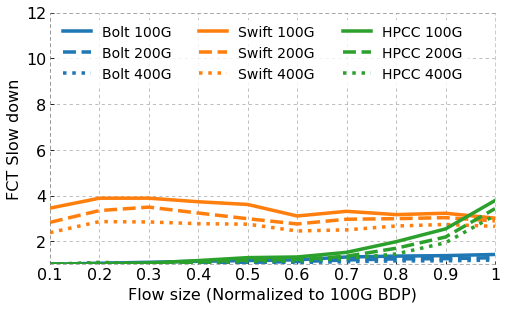

In [13]:
#@title
print(workload + ' - ' + note)
plt.figure(figsize = FIG_SIZE)

for algo in algorithms_to_plot:
  for bw in BWs:
    bw_gbps = int(bw/1e9)
    sdData = slowDownData[(algo,bw_gbps)]

    label = algo + ' ' + str(bw_gbps) + 'G'
    if (algo == 'Bolt'):
      color = 'C0'
    elif (algo == 'Swift'):
      color = 'C1'
    elif (algo == 'HPCC'):
      color = 'C2'
    else:
      print("ERROR choosing the line color for {}!".format(algo))

    percentiles = [x for x,_,_,_,_,_,_ in sdData['res']]
    sd_50p = [x for _,_,x,_,_,_,_ in sdData['res']]
    plt.plot(percentiles, sd_50p, label=label, color=color, 
            linestyle=LINES[BWs.index(bw)], linewidth=3.5)

# plt.yscale('log')
plt.ylim([1,12])
# yticks = [1,5,10]
# plt.yticks(yticks, yticks)
plt.yticks(fontsize=FONT_SIZE)
plt.xlim([0,(100-STEP)/100])
plt.xticks(xticks_orig, xticks, rotation=0, fontsize=FONT_SIZE)

# plt.title('FCT Slow Down for Median and Tail', fontsize=FONT_SIZE)
plt.ylabel('FCT Slow down', fontsize=FONT_SIZE)
plt.xlabel('Flow size (Normalized to 100G BDP)', fontsize=FONT_SIZE)

if (len(algorithms_to_plot) > 2):
  frameon = True
else:
  frameon = False
plt.legend(frameon=frameon, fontsize=FONT_SIZE-2, 
           ncol=len(algorithms_to_plot), loc='upper left', edgecolor='white')

# locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(1,3.3,6.6,10)) 
# plt.gca().yaxis.set_minor_locator(locmin)
# plt.gca().yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.grid(axis='both', which='both', linestyle =LINESTYLE)

plt.gca().spines["right"].set_linestyle(LINESTYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["top"].set_linestyle(LINESTYLE)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["top"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINESTYLE)
plt.gca().spines["left"].set_alpha(0.75)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["bottom"].set_linestyle(LINESTYLE)
plt.gca().spines["bottom"].set_alpha(0.75)
plt.gca().spines["bottom"].set_color('gray')
plt.tight_layout()

plt.gca().tick_params(axis="both", which='both', direction="in", 
                      left=True, labelleft=True)
if (SAVE_FIG):
  cc_list_str = ''
  for algo in algorithms_to_plot:
    cc_list_str += '_' + algo
  save_folder = '/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/'
  save_filename = 'fct_' + workload + '_load-' + str(int(load*100)) + 'p' + note + '_50p' + cc_list_str + '.pdf'
  plt.savefig(save_folder + save_filename)
  print('Saved: ' + save_folder + save_filename)
plt.show()

Google_RPC_read - _incLineRates


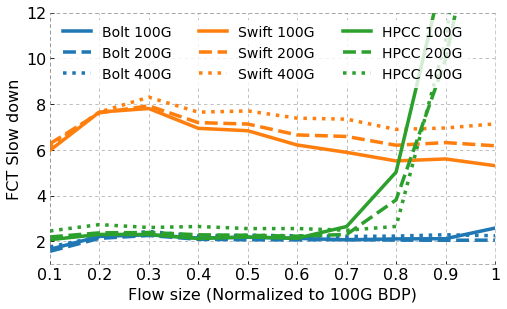

In [15]:
#@title
print(workload + ' - ' + note)
plt.figure(figsize = FIG_SIZE)

for algo in algorithms_to_plot:
  for bw in BWs:
    bw_gbps = int(bw/1e9)
    sdData = slowDownData[(algo,bw_gbps)]

    label = algo + ' ' + str(bw_gbps) + 'G'
    if (algo == 'Bolt'):
      color = 'C0'
    elif (algo == 'Swift'):
      color = 'C1'
    elif (algo == 'HPCC'):
      color = 'C2'
    else:
      print("ERROR choosing the line color for {}!".format(algo))

    percentiles = [x for x,_,_,_,_,_,_ in sdData['res']]
    sd_99p = [x for _,_,_,_,_,x,_ in sdData['res']]
    plt.plot(percentiles, sd_99p, label=label, color=color, 
            linestyle=LINES[BWs.index(bw)], linewidth=3.5)

# plt.yscale('log')
plt.ylim([1,12])
# yticks = [1,5,10]
# plt.yticks(yticks, yticks)
plt.yticks(fontsize=FONT_SIZE)
plt.xlim([0,(100-STEP)/100])
plt.xticks(xticks_orig, xticks, rotation=0, fontsize=FONT_SIZE)

# plt.title('FCT Slow Down for Median and Tail', fontsize=FONT_SIZE)
plt.ylabel('FCT Slow down', fontsize=FONT_SIZE)
plt.xlabel('Flow size (Normalized to 100G BDP)', fontsize=FONT_SIZE)
if (len(algorithms_to_plot) > 2):
  frameon = True
else:
  frameon = False
plt.legend(frameon=frameon, fontsize=FONT_SIZE-2, 
           ncol=len(algorithms_to_plot), loc='upper left', edgecolor='white')

# locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(1,3.3,6.6,10)) 
# plt.gca().yaxis.set_minor_locator(locmin)
# plt.gca().yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.grid(axis='both', which='both', linestyle =LINESTYLE)

plt.gca().spines["right"].set_linestyle(LINESTYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["top"].set_linestyle(LINESTYLE)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["top"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINESTYLE)
plt.gca().spines["left"].set_alpha(0.75)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["bottom"].set_linestyle(LINESTYLE)
plt.gca().spines["bottom"].set_alpha(0.75)
plt.gca().spines["bottom"].set_color('gray')
plt.tight_layout()

plt.gca().tick_params(axis="both", which='both', direction="in", 
                      left=True, labelleft=True)
if (SAVE_FIG):
  cc_list_str = ''
  for algo in algorithms_to_plot:
    cc_list_str += '_' + algo
  save_folder = '/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/'
  save_filename = 'fct_' + workload + '_load-' + str(int(load*100)) + 'p' + note + '_99p' + cc_list_str + '.pdf'
  plt.savefig(save_folder + save_filename)
  print('Saved: ' + save_folder + save_filename)
plt.show()